In [2]:
import sys
sys.path.append('../')

sys.path = sys.path + ['/home/joaom/projects/geobr/python-package/.env/lib/python3.7/site-packages']

In [201]:
import geobr
import geopandas as gpd
from s2 import s2
import geojson
import matplotlib.pyplot as plt
%matplotlib inline

# Get Data

In [4]:
health = geobr.read_health_facilities()

In [21]:
health.head()

,code_cnes,code_muni,code_state,abbrev_state,date_update,year_update,data_source,geometry
0,2684403,412510,41.0,PR,2015-05-27,2015.0,PMAQ,POINT (-50.297 -25.683)
1,2684411,412510,41.0,PR,2015-05-27,2015.0,PMAQ,POINT (-50.3932356834397 -25.6550717353813)
2,2684438,412510,41.0,PR,2015-05-27,2015.0,PMAQ,POINT (-50.3013968467698 -25.6877624988548)
3,2576694,412520,41.0,PR,2015-05-27,2015.0,PMAQ,POINT (-52.91799999999999 -25.706)
4,2583372,412520,41.0,PR,2015-05-27,2015.0,PMAQ,POINT (-52.91799999999999 -25.706)


In [5]:
states = geobr.read_state(code_state='all', year=2010)

In [7]:
states.head()

,code_state,abbrev_state,name_state,code_region,name_region,geometry,brasil
0,11.0,RO,Rondônia,1.0,Norte,POLYGON ((-63.32720817710296 -7.97672029882056...,brasil
1,12.0,AC,Acre,1.0,Norte,POLYGON ((-73.18252539408962 -7.33549646429577...,brasil
2,13.0,AM,Amazonas,1.0,Norte,POLYGON ((-67.32608847052386 2.029713905720171...,brasil
3,14.0,RR,Roraima,1.0,Norte,POLYGON ((-60.20050657607426 5.264343437750694...,brasil
4,15.0,PA,Pará,1.0,Norte,(POLYGON ((-54.95430669626876 2.58369242348219...,brasil


In [15]:
states.query('abbrev_state == "PA"')

,code_state,abbrev_state,name_state,code_region,name_region,geometry,brasil
4,15.0,PA,Pará,1.0,Norte,(POLYGON ((-54.95430669626876 2.58369242348219...,brasil


# Select State

In [22]:
state = 'PA'

In [23]:
h_state = health.query(f'abbrev_state == "{state}"')

In [24]:
s_state = states.query(f'abbrev_state == "{state}"')

# Fill state with grid

In [ ]:
from shapely.wkt import loads

In [78]:
resolution = 8 # about 27 - 38 km square https://s2geometry.io/resources/s2cell_statistics.html

In [138]:
geo_json = geojson.Feature(geometry=s_state.geometry[0], properties={})
geo_json['geometry']['coordinates'] = geo_json['geometry']['coordinates'][0]
grid = s2.polyfill(geo_json['geometry'], resolution, geo_json_conformant=True) 
grids = [s2._geo_to_wkt(g) for g in grid]
grids = gpd.GeoDataFrame({'geometry': [loads(s2._geo_to_wkt(g)) for g in grid]})

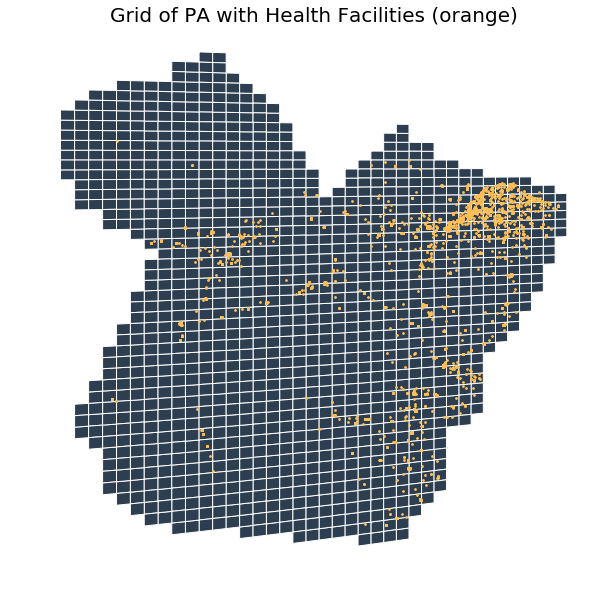

In [137]:
ax = grids.plot(facecolor='#2D3E50', edgecolor='white', figsize=(10,10))

ax = h_state.plot(color='#FEBF57', markersize=3, ax=ax)

ax.set_title(f'Grid of {state} with Health Facilities (orange)', fontsize=20)
ax.axis('off')

None

# Calculate health facilities distance from grids

In [177]:
from geopy.distance import geodesic
from pandarallel import pandarallel
pandarallel.initialize()

def latlon(p):
    return (p.x, p.y)

def distance(p1, p2):   
    return geodesic(latlon(p1), latlon(p2)).kilometers

def distance_from_points(p1, p2s):
    return min((distance(p1, p2) for p2 in p2s.tolist()))

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [178]:
grids['minimum_dist'] = grids['geometry'].centroid.parallel_apply(lambda x: distance_from_points(x, h_state['geometry']))

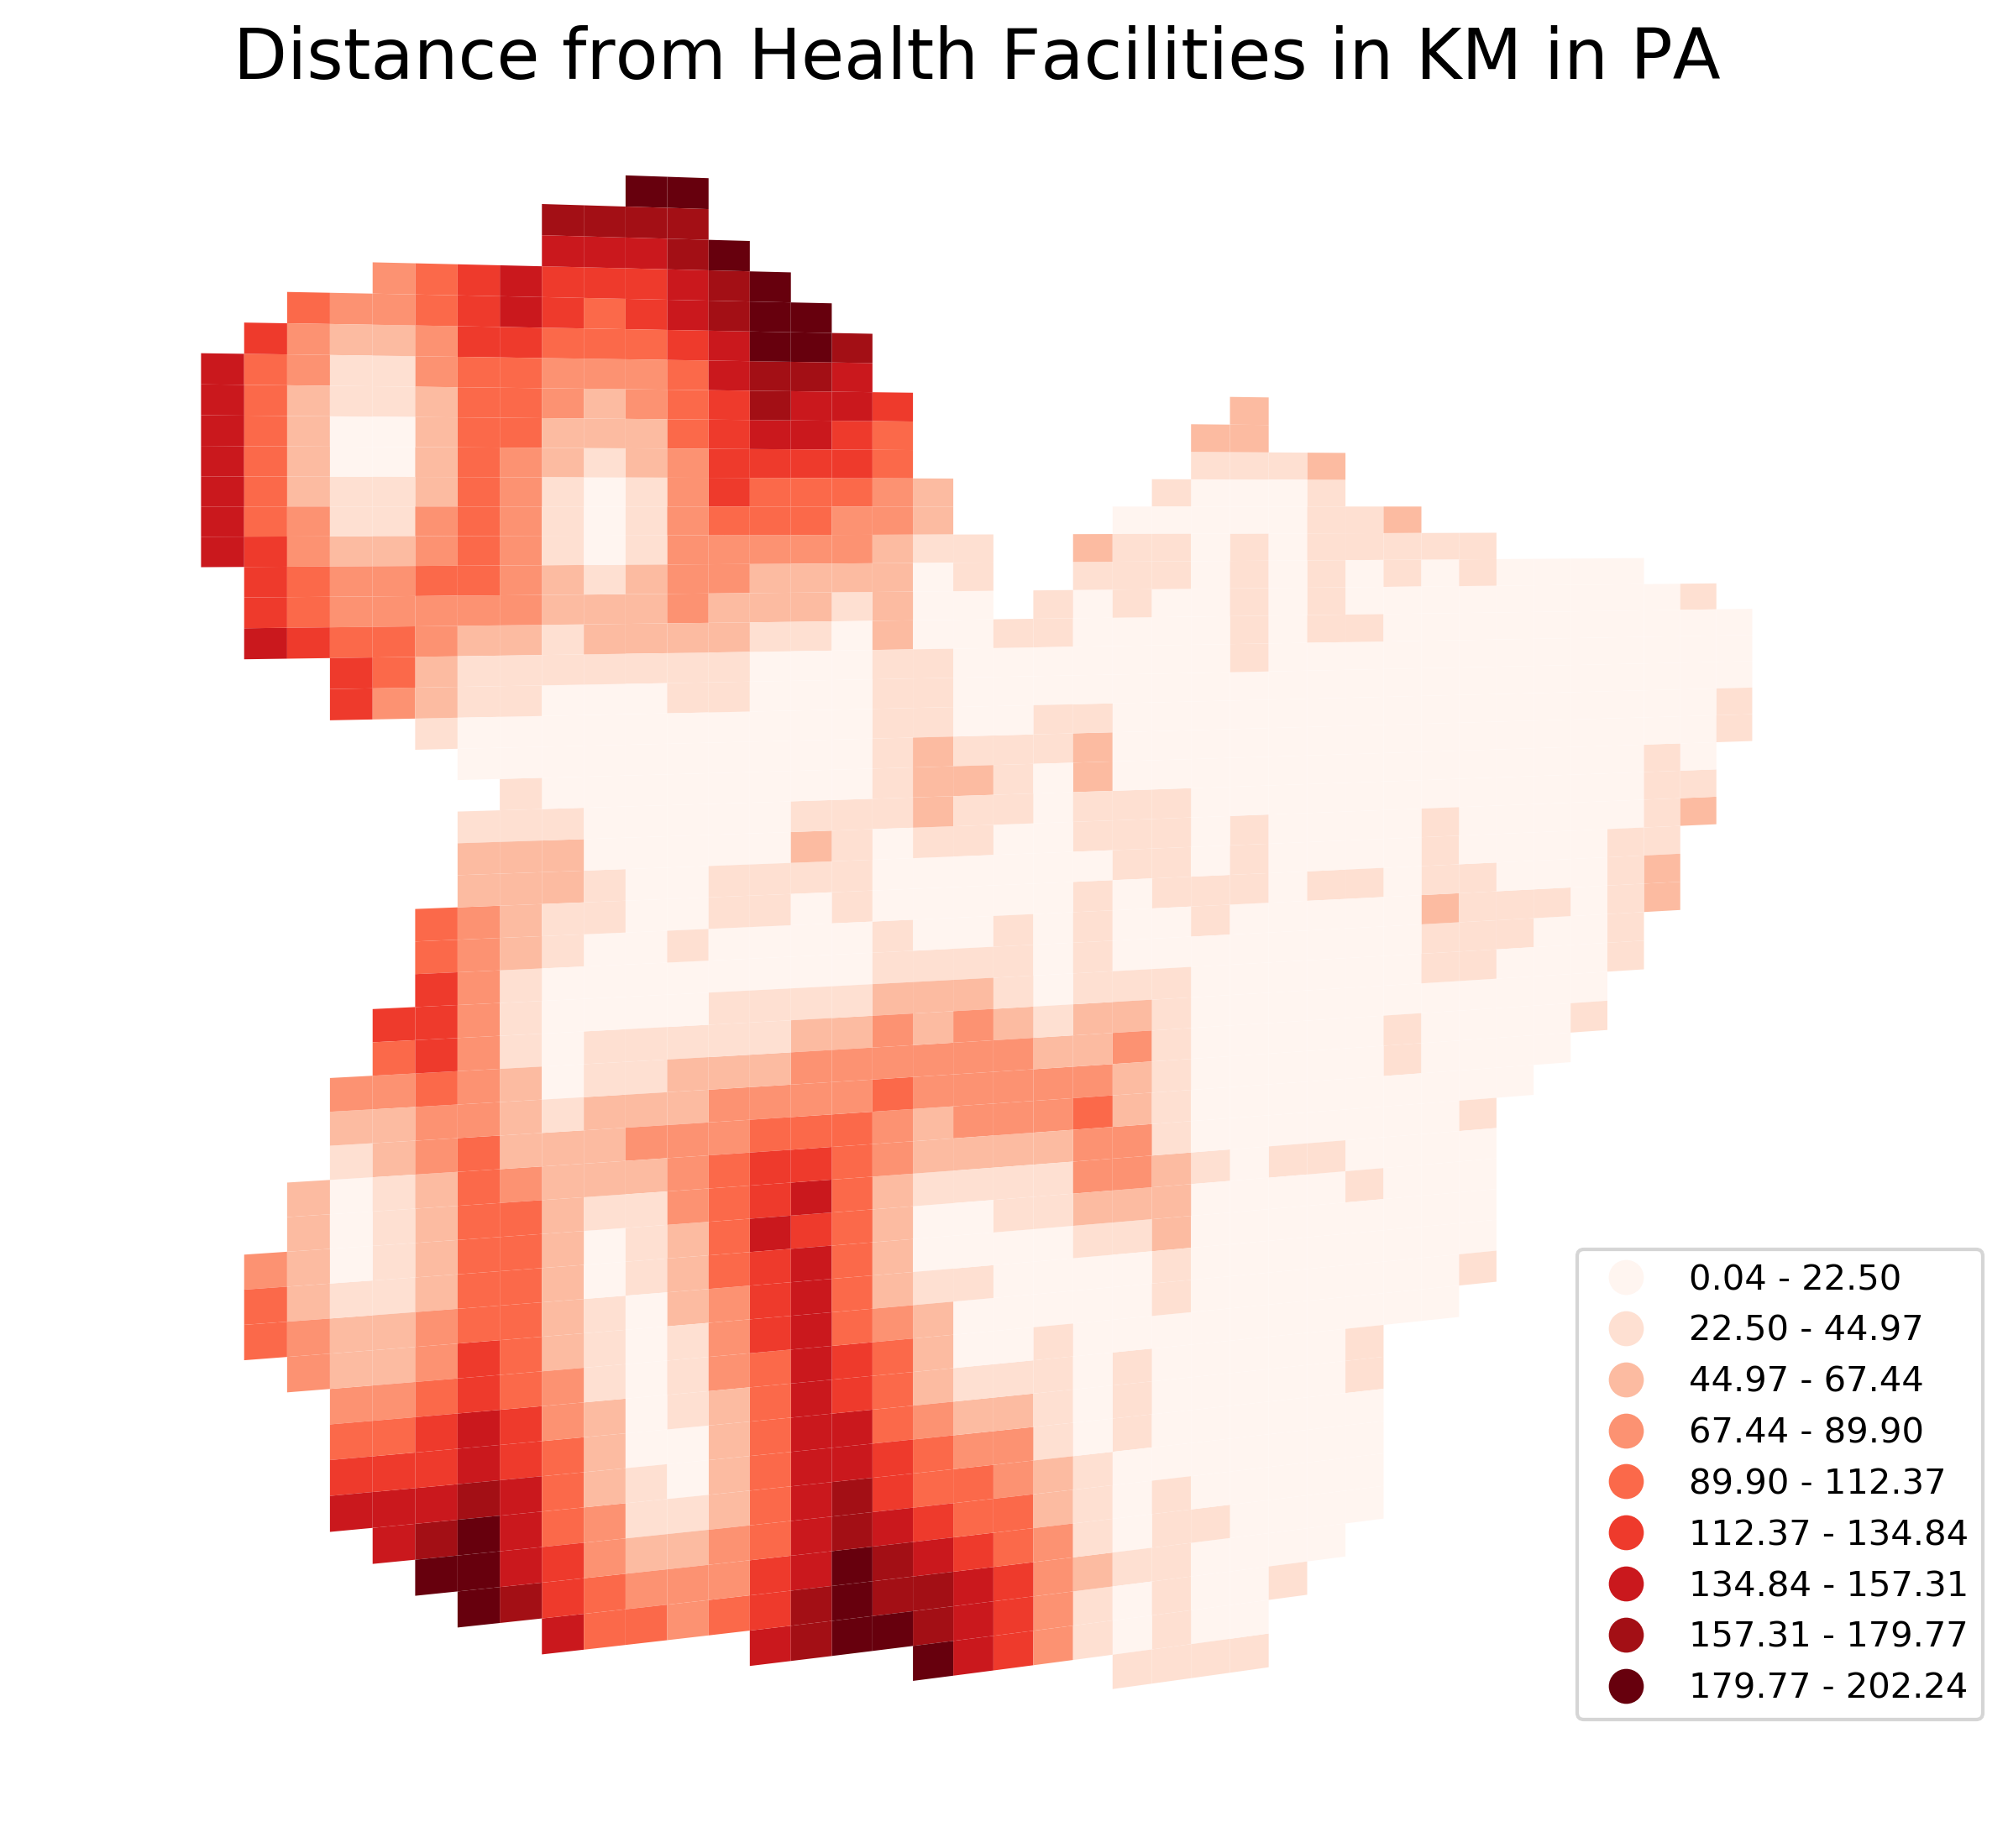

In [216]:
cmap = 'Reds'
colors = 9
figsize = (8, 8)

fig, ax = plt.subplots(nrows=1, ncols=1,
                      figsize=figsize, dpi=300)

ax = grids.plot(column='minimum_dist', cmap=cmap, figsize=figsize, scheme='equal_interval', k=colors, legend=True, ax=ax)
ax.set_title(f'Distance from Health Facilities in KM in {state}', fontsize=20)
ax.set_axis_off()
ax.get_legend().set_bbox_to_anchor((1.1, .32))

fig.tight_layout()
fig.savefig(f'imgs/distance_from_health_facilities_{state}.png')